In [25]:
import numpy as np
from numpy.linalg import inv
from math import cos, sin, tan, pi, floor, inf
from image import Image #Importation bibliothèque image (TP1-Math202)

In [26]:
# 1. Projection

# Fonctions transformation dans le monde

def dilatation(v, Cx, Cy, Cz):
    """
    Cx, Cy, Cz les coefficients de dilatation par axe
    v : les coordonnées x,y,z du point
    """
    #Multiplication avec numpy (.dot(a,b))
    return np.dot(v, [[Cx,0,0],[0,Cy,0],[0,0,Cz]])

def rotation(v, axe, angle):
    """
    v = [x,y,z] tab
    axe = "x", "y" ou "z" str
    angle = float en degré
    """

    a = (angle*pi)/180 #Passage de l'angle en radian
    c = cos(a)
    s = sin(a)

    #Test pour trouver la bonne matrice de rotation
    if axe == "x":
        m_rotation = [[1,0,0],[0,c,-s],[0,s,c]]
    elif axe == "y":
        m_rotation = [[c,0,s],[0,1,0],[-s,0,c]]
    elif axe == "z":
        m_rotation = [[c,-s,0],[s,c,0],[0,0,1]]
    else:
        print("Erreur axe: 'x', 'y' ou 'z'")
        m_rotation = [[1,0,0],[0,1,0],[0,0,1]]
        
    return np.dot(v, m_rotation)

def translation(v, Tx, Ty, Tz):
    """
    v = [x,y,z,1]
    Tx, Ty, Tz = entier
    """

    #Si la coordonnée est toujours de taille 1*3 et non 1*4
    if len(v) != 4:
        return print("Erreur: v = [x,y,z,1]")
    return np.dot(v, [[1,0,0,0],[0,1,0,0],[0,0,1,0],[Tx,Ty,Tz,1]])

def matrice_T(d, r, t):
    """
    d = [dx,dy,dz] Les coefficients de dilatation sur chaque axe
    r = [ax,ay,az] Les angles de rotation autour de chaque axe
    t = [tx,ty,tz] Les coefficients de translation sur chaque axe
    """
    
    tra = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[t[0],t[1],t[2],1]] #Matrice translation
    dil = [[d[0],0,0,0],[0,d[1],0,0],[0,0,d[2],0],[0,0,0,1]] #Matrice dilatation
    a = (r[0]*pi)/180
    c = cos(a)
    s = sin(a)
    Rx = [[1,0,0,0],[0,c,-s,0],[0,s,c,0],[0,0,0,1]]
    a = (r[1]*pi)/180
    c = cos(a)
    s = sin(a)
    Ry = [[c,0,s,0],[0,1,0,0],[-s,0,c,0],[0,0,0,1]]
    a = (r[2]*pi)/180
    c = cos(a)
    s = sin(a)
    Rz = [[c,-s,0,0],[s,c,0,0],[0,0,1,0],[0,0,0,1]]
    rot = np.dot(Rx,Ry)
    rot = np.dot(rot, Rz) #Matrice rotation

    #Multiplication des trois sous-matrices
    T = np.dot(dil, rot)
    T = np.dot(T, tra)
    
    return T

#Fonction local vers monde n'utilisant pas la fonction Matrice_T afin
#d'illustrer le fonctionnement

def local_vers_monde_v1(v, d, r, t):
    """
    v = [x,y,z] Les coordonnées de base du point
    d = [dx,dy,dz] Les coefficients de dilatation sur chaque axe
    r = [ax,ay,az] Les angles de rotation autour de chaque axe
    t = [tx,ty,tz] Les coefficients de translation sur chaque axe
    """
    
    v_proj = dilatation(v,d[0],d[1],d[2])
    tab = ["x","y","z"]
    for i in range(3):
            v_proj = rotation(v_proj, tab[i], r[i])
    v_proj = np.insert(v_proj,v_proj.size,1)
    point_monde = translation(v_proj, t[0], t[1], t[2])
    return point_monde


# Procedure détaillée de la projection

#Fonction local vers monde utilisant fonction Matrice_T
#plus pertinante

def local_vers_monde(point, d, r, t):
    """
    point = [x,y,z,1] Les coordonnées de base du point
    d = [dx,dy,dz] Les coefficients de dilatation sur chaque axe
    r = [ax,ay,az] Les angles de rotation autour de chaque axe
    t = [tx,ty,tz] Les coefficients de translation sur chaque axe
    """
    #Deduction de la matrice transformation
    T = matrice_T(d, r, t)
    #multiplication
    point_monde = np.dot(point,T)
    
    return point_monde

def monde_vers_camera(point,dc,tc,rc):
    """
    Projection du point dans le monde vers la camera
    """

    #Projection camera dans monde puis monde dans camera
    camera_monde = matrice_T([1,1,1], tc, rc) #V
    camera_local = inv(camera_monde) #V^-1

    #Projection du point dans l'espace camera
    point_camera = np.dot(camera_local,point)
    
    return point_camera

def matrice_P(fov, n, f):
    """
    Calcul de la matrice perspective tel que vu dans le wiki
    fov : champ de vision en degré
    n : distance premier plan
    f : distance arriere plan
    """
    s = 1/(tan((fov/2)*(pi/180)))
    return [[s,0,0,0],[0,s,0,0],[0,0,-f/(f-n),-(f*n)/(f-n)],[0,0,0,-1]]

def camera_vers_ecran(point,fov,proche,lointain):
    """
    Projection du point sur l'ecran de la camera
    """
    
    #Creation de la matrice perspective
    perspective = matrice_P(fov, proche, lointain)

    #Projection du point sur l'ecran
    point_ecran = np.dot(point,perspective)
    
    return point_ecran[:-1] #[:-1] car l'on peut desormait travaiiler sur (x,y,z)
                            # et non (x,y,z,1)

def ecran_vers_normalise(point, largeur, hauteur):
    """
    Transformation du point aux coordonnees normalisees
    """
    
    p = point
    l = largeur
    h = hauteur
    #Si le point est comprit dans l'image
    if (abs(p[0]) <= l/2) or (abs(p[1]) <= h/2):
        #Transformation normalisée (NDC space)
        p[0] = (p[0]+l/2)/l
        p[1] = (p[1]+h/2)/h
        return p
    return None

def normalise_vers_grille(point, l, h):
    """
    Transformation du point aux coordonnees pixel
    """
    
    p = point
    p[0] = floor(p[0]*l)
    p[1] = floor((1-p[1])*h)
    return p

# Resultat final

def procedure_local_grille(point_local,index,couleur,dp,rp,tp,dc,rc,tc,fov,proche,lointain,largeur,hauteur):
    """
    Transformation totale du point local vers l'espace raster
    """
    
    point_monde = local_vers_monde(point_local,dp,rp,tp)
    point_camera = monde_vers_camera(point_monde,dc,rc,tc)
    point_ecran = camera_vers_ecran(point_camera,fov,proche,lointain)
    point_normalise = ecran_vers_normalise(point_ecran, largeur, hauteur)
    point_grille = normalise_vers_grille(point_normalise, largeur, hauteur)
    x = point_grille[0]
    y = point_grille[1]
    coords = (int(x),int(y),point_grille[2])
    return (coords,index,couleur)   #Ajout d'un index et de la couleur necessaire
                                    #à la visualisation
        


# 2. Visualisation

# Recupération des coordonnées comprisent dans un triangle

def ordre(s1,s2,s3):
    """
    Retourne l'ordre des sommets grace à leur index
    s = ((x,y,z),i)
    """
    
    tuples = [s1,s2,s3]
    return sorted(tuples, key=lambda tuples: tuples[1])

def boite(s1,s2,s3):
    """
    Génération de la plus petite boite englobant le triangle
    """
    
    boite_start = (min(s1[0],s2[0],s3[0]),min(s1[1],s2[1],s3[1]))
    boite_end = (max(s1[0],s2[0],s3[0]),max(s1[1],s2[1],s3[1]))
    
    return (boite_start,boite_end) #(xmin,ymin),(xmax,ymax)

def interieur_bordure(s1,s2,pixel):
    """
    Calcul le déterminant D pour ensuite tester si le pixel est dans le triangle
    """
    
    return ((pixel[0] - s2[0]) * (s1[1] - s2[1]) - (pixel[1] - s2[1]) * (s1[0] - s2[0]))

def liste_pixels_coeffs(s1,s2,s3):
    """
    Retourne la listes des pixels dans le triangle ainsi que leurs coefficients
    par rapport à chaque sommets
    """
    
    b = boite(s1,s2,s3)
    points = []
    coeffs = []
    #Aire du triangle complet
    aire = interieur_bordure(s1,s2,s3)
    #Parcours de la bounding box
    for i in range(b[0][0],b[1][0]+1):
        for j in range(b[0][1],b[1][1]+1):
            #Calcul des sous-aires
            aire3 = interieur_bordure(s1,s2,(i,j))
            aire1 = interieur_bordure(s2,s3,(i,j))
            aire2 = interieur_bordure(s3,s1,(i,j))
            #Si le pixel est à l'interieur des trois bords du triangle
            if aire1 >= 0 and aire2 >= 0 and aire3 >= 0:
                #Coordonnées barycentriques
                coeff = ((aire1/aire,aire2/aire,aire3/aire))
                #Calcul de la profondeur par rapport aux coords barycentriques
                z = coeff[0]*s1[2]+coeff[1]*s2[2]+coeff[2]*s3[2]
                points.append((i,j,z))
                coeffs.append(coeff)
    return (points,coeffs)

def calculer_rgb(c1,c2,c3,liste):
    """
    Calcul de la couleur du pixel
    """
    
    #Liste des points du triangle et de leur coeff
    finale = liste[0]
    k = 0
    for i in liste[1]:
        cf1 = i[0]
        cf2 = i[1]
        cf3 = i[2]
        
        couleur = ()

        #Pour chaque composante (r, g et b)
        for j in range(3):
            #Nouvelle couleur
            c = floor(cf1*c1[j]+cf2*c2[j]+cf3*c3[j])
            couleur += (c,)
        #Correspondance du point et de la couleur (ecrase les coord barycentriques)
        finale[k] = (finale[k],couleur)
        k += 1
    return finale

def remplir(s1,s2,s3):
    """
    Renvoie la liste des pixels ainsi que leur couleur
    s = ((x,y,z),i,(r,g,b))
    """
    
    o = ordre(s1,s2,s3)
    liste = liste_pixels_coeffs(o[0][0],o[1][0],o[2][0])
    return calculer_rgb(s1[2],s2[2],s3[2],liste)

# Image

def creer_image(l,h,fond,fichier):
    """
    Création d'une image vierge
    l = largeur
    h = hauteur
    fichier = fichier de sortie
    fond = couleur du fond (r,g,b)
    """

    #ouverture du fichier en mode lecture
    image = open(fichier,"w")
    image.write("P3\n"+str(l)+" "+str(h)+"\n255\n")
    #Mettre tous les pixels à la couleur du fond
    for i in range(h):
        for j in range(l):
            image.write(str(fond[0])+" "+str(fond[1])+" "+str(fond[2])+"\n")
    #fermeture du fichier
    image.close()
    return None

def rendu(liste,fichier):
    """
    Ecrit les nouveaux pixel sur l'image
    """
    
    im = Image(fichier)
    for i in liste:
        x = i[0][0]
        y = i[0][1]
        c = i[1]
        #Mise à jour des nouveaux pixels avec leur couleur
        im.setPixel(x,y,c)
        
    im.save(fichier)
    return None

def rendu_total(l,h,fond,fichier,liste):
    """
    Créé l'image en partant des dimensions et de la liste de pixels
    """
    
    creer_image(l,h,fond,fichier)
    rendu(liste,fichier)
    return None


# Quelques exemples
def exemple_1():
    rendu_total(10,10,(0,0,0),"rendu10x10.ppm",remplir(((0,6,2),1,(255,0,0)),((4,0,-5),2,(0,255,0)),((6,4,0),3,(0,0,255))))
    rendu_total(600,400,(0,0,0),"rendu600x400_1.ppm",remplir(((100,200,2),1,(255,0,0)),((400,50,-5),2,(0,255,0)),((550,350,0),3,(0,0,255))))
    rendu_total(600,400,(0,0,0),"rendu600x400_2.ppm",remplir(((100,350,2),1,(255,255,0)),((550,50,-5),2,(0,255,255)),((550,300,0),3,(255,0,255))))
    rendu_total(600,400,(0,0,0),"rendu600x400_3.ppm",remplir(((100,350,2),1,(0,100,0)),((550,50,-5),2,(0,150,0)),((550,300,0),3,(0,200,0))))
    return "Rendu terminé"

# Implementation du z-buffer

def initialisation_z_buffer(l,h):
    """
    Creation d'un tableau 2D avec chaque case = -inf
    """
    z_buffer = []
    #Ligne
    for i in range(0,h):
        z_buffer.append([])
        for j in range(0,l):
            z_buffer[i].append(-inf)
    return z_buffer

def cache(z_buffer,p):
    """
    Test si un pixel est cache
    """
    
    if p[2] <= z_buffer[p[1]][p[0]]:
        return True
    return False

def modifier_z_buffer(z_buffer,p):
    """
    Modifie la case avec la nouvelle profondeur
    """
    
    z_buffer[p[1]][p[0]] = p[2]
    return z_buffer

def rendu_z_buffer(liste,fichier,z_buffer):
    """
    Rendu de l'image en prenant compte le z-buffer
    """

    #Ouverture de l'image
    im = Image(fichier)
    for i in liste:
        x = i[0][0]
        y = i[0][1]
        z = i[0][2]
        c = i[1]
        #tests z-buffer
        if not cache(z_buffer,(x,y,z)):
            z_buffer = modifier_z_buffer(z_buffer,(x,y,z))
            im.setPixel(x,y,c)
    #Sauvegarde de l'image
    im.save(fichier)
    return None

# Algorithme final

def rasterisation(triangles,c,image):
    """
    triangles : [[[[(x,y,z),index,couleur],[(x,y,z),index,couleur],[(x,y,z),index,couleur]],dp,rp,tp],triangle2...]
    c (camera) : [dc,rc,tc,fov,proche,lointain]
    image : [largeur,hauteur,fond,fichier_sortie]
    """
    points_p = []
    triangles_p = []
    l = image[0]
    h = image[1]
    fond = image[2]
    fichier = image[3]
    #Pour chaque triangle
    for t in triangles:
        #Pour chaque point
        for p in t[0]:
            point = p[0]+(1,)
            points_p.append(procedure_local_grille(point,p[1],p[2],t[1],t[2],t[3],c[0],c[1],c[2],c[3],c[4],c[5],l,h))
        #Ajout du nouveau point
        triangles_p.extend([points_p])
        points_p = []
    liste_pixels_t = []
    #Pour chaque triangle projete
    for t in triangles_p:
        liste_pixels_t.append(remplir(t[0],t[1],t[2]))
    #Initialisation z-buffer global car reutilise dans plusieurs fonctions
    global z_buffer
    z_buffer = initialisation_z_buffer(l,h)
    creer_image(l,h,fond,fichier)
    #Test z-buffer
    for p in liste_pixels_t:
        rendu_z_buffer(p,fichier,z_buffer)
    
    return ("Rendu terminé")


def exemple_2(i):
    """
    Avec i compris entre 01 et nombres d'exemple
    """

    if i == 1:
        triangle1 = [[[(1,200.5,10),2,(255,0,0)],[(50,2,3),1,(0,255,0)],[(250,300,20),3,(0,0,255)]],[2,0.5,1],[1,2,3],[90,0,0]]
        triangle2 = [[[(100,100,15),2,(255,255,0)],[(300,5,5),1,(0,255,255)],[(280,400,2),3,(255,0,255)]],[1,0.5,1],[2,2,3],[0,90,0]]
        camera = [[1,1,1],[0,5,0],[0,0,180],100,1,100]
        image = [1080,960,(0,0,0),"out1.ppm"]
        rasterisation([triangle1,triangle2],camera,image)

    if i == 2:
        triangle1 = [[[(1,200.5,10),2,(255,0,0)],[(50,2,3),1,(0,255,0)],[(250,300,20),3,(0,0,255)]],[2,0.5,1],[1,2,3],[90,0,0]]
        camera = [[1,1,1],[0,5,0],[0,0,180],100,1,100]
        image = [1080,960,(0,0,0),"out2.ppm"]
        rasterisation([triangle1],camera,image)
        
    if i == 3:
        triangle1 = [[[(1,200,10),2,(255,0,0)],[(-50,2,3),1,(0,255,0)],[(250,300,20),3,(0,0,255)]],[0.1,0.1,0.1],[1,2,3],[90,0,0]]
        triangle2 = [[[(100,100,15),2,(255,0,0)],[(300,5,5),1,(0,255,0)],[(280,400,2),3,(0,0,255)]],[0.5,0.1,0.1],[-50,2,3],[0,90,0]]
        camera = [[1,1,1],[0,5,0],[0,0,180],90,1,100]
        image = [500,250,(150,150,150),"out3.ppm"]
        rasterisation([triangle1,triangle2],camera,image)
        
    if i == 4:
        triangle1 = [[[(1,200,10),2,(255,0,0)],[(-50,2,3),1,(0,255,0)],[(250,300,20),3,(0,0,255)]],[0.1,0.1,0.1],[1,2,3],[90,0,0]]
        triangle2 = [[[(100,100,15),2,(255,0,0)],[(300,5,5),1,(0,255,0)],[(280,400,2),3,(0,0,255)]],[0.5,0.1,0.1],[-50,2,3],[0,90,0]]
        camera = [[1,1,1],[0,5,0],[0,0,180],100,1,100]
        image = [500,250,(150,150,150),"out4.ppm"]
        rasterisation([triangle1,triangle2],camera,image)
        
    if i == 5:
        triangle1 = [[[(1,200,10),2,(255,0,0)],[(-50,2,3),1,(0,255,0)],[(250,300,20),3,(0,0,255)]],[0.1,0.1,0.1],[1,2,3],[90,0,0]]
        triangle2 = [[[(100,100,15),2,(255,0,0)],[(300,5,5),1,(0,255,0)],[(280,400,2),3,(0,0,255)]],[0.5,0.1,0.1],[-50,2,3],[0,90,0]]
        camera = [[1,1,1],[0,5,0],[0,0,180],110,1,100]
        image = [500,250,(150,150,150),"out5.ppm"]
        rasterisation([triangle1,triangle2],camera,image)
        
    if i == 6:
        triangle1 = [[[(1,200.5,10),2,(255,0,0)],[(50,2,3),1,(0,255,0)],[(250,300,20),3,(0,0,255)]],[2,0.5,1],[-10,2,3],[90,0,0]]
        triangle2 = [[[(100,100,15),2,(255,255,0)],[(300,5,5),1,(0,255,255)],[(280,400,2),3,(255,0,255)]],[1,0.5,1],[-50,2,3],[0,90,0]]
        triangle3 = [[[(-50,500,-5),2,(220,220,220)],[(-40,10,5),1,(255,255,255)],[(200,200,100),3,(20,20,20)]],[1,0.5,1],[0,0,0],[-300,0,0]]
        camera = [[1,1,1],[0,0,0],[0,0,0],110,1,100]
        image = [1080,960,(0,0,0),"out6.ppm"]
        rasterisation([triangle1,triangle2,triangle3],camera,image)

        triangle1 = [[[(1,200.5,10),2,(255,0,0)],[(50,2,3),1,(0,255,0)],[(250,300,20),3,(0,0,255)]],[2,0.5,1],[-10,2,3],[90,0,0]]
        triangle2 = [[[(100,100,15),2,(255,255,0)],[(300,5,5),1,(0,255,255)],[(280,400,2),3,(255,0,255)]],[1,0.5,1],[-50,2,3],[0,90,0]]
        triangle3 = [[[(-50,500,-5),2,(220,220,220)],[(-40,10,5),1,(255,255,255)],[(200,200,100),3,(20,20,20)]],[1,0.5,1],[0,0,180],[-300,0,0]]
        camera = [[1,1,1],[0,0,0],[0,0,0],110,1,100]
        image = [1080,960,(0,0,0),"out6-1.ppm"]
        rasterisation([triangle1,triangle2,triangle3],camera,image)

        triangle1 = [[[(1,200.5,10),2,(255,0,0)],[(50,2,3),1,(0,255,0)],[(250,300,20),3,(0,0,255)]],[2,0.5,1],[-10,2,3],[90,0,0]]
        triangle2 = [[[(100,100,15),2,(255,255,0)],[(300,5,5),1,(0,255,255)],[(280,400,2),3,(255,0,255)]],[1,0.5,1],[-50,2,3],[0,90,0]]
        triangle3 = [[[(-50,500,-5),2,(220,220,220)],[(-40,10,5),1,(255,255,255)],[(200,200,1000),3,(20,20,20)]],[1,0.5,1],[0,0,0],[100,0,0]]
        camera = [[1,1,1],[0,0,0],[0,0,0],110,1,100]
        image = [1080,960,(0,0,0),"out6-2.ppm"]
        rasterisation([triangle1,triangle2,triangle3],camera,image)

        triangle1 = [[[(1,200.5,10),2,(255,0,0)],[(50,2,3),1,(0,255,0)],[(250,300,20),3,(0,0,255)]],[2,0.5,1],[-10,2,3],[90,0,0]]
        triangle2 = [[[(100,100,15),2,(255,255,0)],[(300,5,5),1,(0,255,255)],[(280,400,2),3,(255,0,255)]],[1,0.5,1],[-50,2,3],[0,90,0]]
        triangle3 = [[[(-50,500,-5),2,(220,220,220)],[(-40,10,5),1,(255,255,255)],[(200,200,500),3,(20,20,20)]],[1,0.5,1],[0,0,0],[200,0,0]]
        camera = [[1,1,1],[0,0,0],[0,0,0],110,1,100]
        image = [1080,960,(0,0,0),"out6-3.ppm"]
        rasterisation([triangle1,triangle2,triangle3],camera,image)

        triangle1 = [[[(1,200.5,10),2,(255,0,0)],[(50,2,3),1,(0,255,0)],[(250,300,20),3,(0,0,255)]],[2,0.5,1],[-10,2,3],[90,0,0]]
        triangle2 = [[[(100,100,15),2,(255,255,0)],[(300,5,5),1,(0,255,255)],[(280,400,2),3,(255,0,255)]],[1,0.5,1],[-50,2,3],[0,0,0]]
        triangle3 = [[[(-50,500,-5),2,(220,220,220)],[(-40,10,5),1,(255,255,255)],[(200,200,500),3,(20,20,20)]],[1,0.5,1],[0,0,0],[200,0,0]]
        camera = [[1,1,1],[0,0,0],[50,0,0],110,1,100]
        image = [1080,960,(0,0,0),"out6-4.ppm"]
        rasterisation([triangle1,triangle2,triangle3],camera,image)

        triangle1 = [[[(1,200.5,10),2,(255,0,0)],[(50,2,3),1,(0,255,0)],[(250,300,20),3,(0,0,255)]],[2,0.5,1],[-10,2,3],[90,0,0]]
        triangle2 = [[[(100,100,15),2,(255,255,0)],[(300,5,5),1,(0,255,255)],[(280,400,2),3,(255,0,255)]],[1,0.5,1],[-50,2,3],[0,180,0]]
        triangle3 = [[[(-50,500,-5),2,(220,220,220)],[(-40,10,5),1,(255,255,255)],[(200,200,500),3,(20,20,20)]],[1,0.5,1],[0,0,0],[200,0,0]]
        camera = [[1,1,1],[0,20,0],[0,0,0],110,1,100]
        image = [1080,960,(0,0,0),"out6-5.ppm"]
        rasterisation([triangle1,triangle2,triangle3],camera,image)

    if i == 7:
        triangle1 = [[[(1,200.5,10),2,(255,0,0)],[(50,2,3),1,(0,255,0)],[(250,300,20),3,(0,0,255)]],[2,0.5,1],[-10,2,3],[90,0,0]]
        triangle2 = [[[(100,100,15),2,(255,255,0)],[(300,5,5),1,(0,255,255)],[(280,400,2),3,(255,0,255)]],[1,0.5,1],[-50,2,3],[0,90,0]]
        triangle3 = [[[(-50,500,-5),2,(255,255,0)],[(-40,10,5),1,(0,255,255)],[(200,200,100),3,(255,0,255)]],[1,0.5,1],[2,2,3],[0,90,0]]
        camera = [[1,1,1],[0,0,180],[0,0,0],110,1,100]
        image = [1080,960,(0,0,0),"out7.ppm"]
        rasterisation([triangle1,triangle2,triangle3],camera,image)
    if i == 8:
        triangle1 = [[[(0,400,0),2,(255,255,0)],[(0,0,0),1,(0,255,0)],[(200,400,0),3,(0,255,255)]],[2,1,1],[0,0,0],[0,0,0]]
        triangle2 = [[[(200,400,0),2,(255,255,0)],[(0,0,0),1,(0,255,255)],[(200,0,0),3,(255,0,255)]],[2,1,1],[0,0,0],[0,0,0]]
        camera = [[1,1,1],[0,0,0],[0,0,0],90,1,100]
        image = [1080,960,(255,225,225),"carre.ppm"]
        rasterisation([triangle1,triangle2],camera,image)
        
    if i == 9:
        dt = [200,200,200]
        rt = [0,0,0]
        tt = [0,0,0]
        r = (255,0,0,127)
        v = (0,255,0,127)
        b = (0,0,255,127)
        c = (0,255,255)
        m = (255,0,255)
        j = (255,255,0)
        triangle1 = [[[(-1,-1,1),1,r],[(-1,1,1),2,r],[(1,1,1),3,r]],dt,rt,tt]
        triangle2 = [[[(-1,-1,1),1,r],[(1,1,1),2,r],[(1,-1,1),3,r]],dt,rt,tt]

        triangle3 = [[[(-1,1,1),1,v],[(-1,1,-1),2,v],[(1,1,1),3,v]],dt,rt,tt]
        triangle4 = [[[(-1,1,-1),1,v],[(1,1,-1),2,v],[(1,1,1),3,v]],dt,rt,tt]

        triangle5 = [[[(1,-1,1),1,b],[(1,1,1),2,b],[(1,1,-1),3,b]],dt,rt,tt]
        triangle6 = [[[(1,-1,-1),1,b],[(1,-1,1),2,b],[(1,1,-1),3,b]],dt,rt,tt]

        triangle7 = [[[(-1,-1,-1),1,c],[(-1,1,1),2,c],[(-1,-1,1),3,c]],dt,rt,tt]
        triangle8 = [[[(-1,-1,-1),1,c],[(-1,1,-1),2,c],[(-1,1,1),3,c]],dt,rt,tt]

        triangle9 = [[[(-1,-1,-1),1,m],[(-1,-1,1),2,m],[(1,-1,1),3,m]],dt,rt,tt]
        triangle10 = [[[(-1,-1,-1),1,m],[(1,-1,1),2,m],[(1,-1,-1),3,m]],dt,rt,tt]

        triangle11 = [[[(1,-1,-1),1,j],[(1,1,-1),2,j],[(-1,1,-1),3,j]],dt,rt,tt]
        triangle12 = [[[(1,-1,-1),1,j],[(-1,1,-1),2,j],[(-1,-1,-1),3,j]],dt,rt,tt]

        cube = [triangle1,triangle2,triangle3,triangle4,triangle5,triangle6,triangle7,triangle8,triangle9,triangle10,triangle11,triangle12]
        camera = [[1,1,1],[-20,20,0],[0,0,0],110,1,100]
        image = [1080,960,(0,0,0),"cube.ppm"]
        rasterisation(cube,camera,image)
    return "Rendu terminé"

#En plus
def getLine(start, end):
    """
    Implementation de l'algorithme de Bresenham que je n'ai pas écrit
    utile pour essayer une autre méthode que la fonction des bords:
    
    Bresenham's Line Algorithm
    Produces a list of tuples from start and end
 
    >>> points1 = get_line((0, 0), (3, 4))
    >>> points2 = get_line((3, 4), (0, 0))
    >>> assert(set(points1) == set(points2))
    >>> print points1
    [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
    >>> print points2
    [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
 
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)
 
    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
 
    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
 
    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1
 
    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
 
    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
 
    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points


In [33]:
exemple_2(9)

'Rendu terminé'

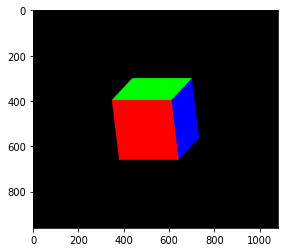

In [35]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread("cube.ppm")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()